# **Project 2b − Bayesian Optimization of Ad-Atom Energy Landscapes**
## Advanced Simulation and Machine Learning | TIF345
## Chalmers University of Technology | Fall 2025
---
### Linus Brink | [brinkl@chalmers.se](mailto:brinkl@chalmers.se) 
### Oscar Stommendal | [oscarsto@chalmers.se](mailto:oscarsto@chalmers.se)
---

## **Setup**

In [1]:

# Imports
import ase
import asap3
import GPy
# from ase.calculators.emt import EMT

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Latex plotting settings
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'palatino'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# General functions
def calculate_adatom_energy(surface, position):
    """Adds adatom to the input surface configuration at the given position
    and relaxes the ad-atoms z-coordinate.

    Parameters
    ----------
    bare_surface
        surface configuration without adatom
    position
        position (x, y, z) at which to insert adatom in Ångström

    Returns
    -------
    tuple comprising the energy of the adatom configuration
    """
    # add adatom
    surface_with_adatom = surface.copy()
    surface_with_adatom.append(ase.Atom('Au', position))

    # attach calculator
    calc = asap3.EMT()
    surface_with_adatom.set_calculator(calc)

    # apply constraints
    constraints = []
    c = ase.constraints.FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = ase.constraints.FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = ase.optimize.BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy = surface_with_adatom.get_potential_energy()
    return energy


## **Task 1: Analyzing the PES**

In [297]:

surface = ase.io.read('data/surface_supercell.xyz')
xmax, ymax = 16.65653, 2.884996
x = np.linspace(0, xmax, 100)
y = np.linspace(0, ymax, 100)
X, Y = np.meshgrid(x, y)

z_adatom = surface.positions[:, 2].max() + 3

def compute_energy_grid(surface, X, Y, z_adatom):
    energy_grid = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            position = [X[i, j], Y[i, j], z_adatom]
            energy = calculate_adatom_energy(surface, position)
            energy_grid[i, j] = energy

    return energy_grid

energy_grid = compute_energy_grid(surface, X, Y, z_adatom)


Global minimum position: x = 3.20 Å, y = 0.73 Å
Global minimum energy: 7.081029339913725 eV


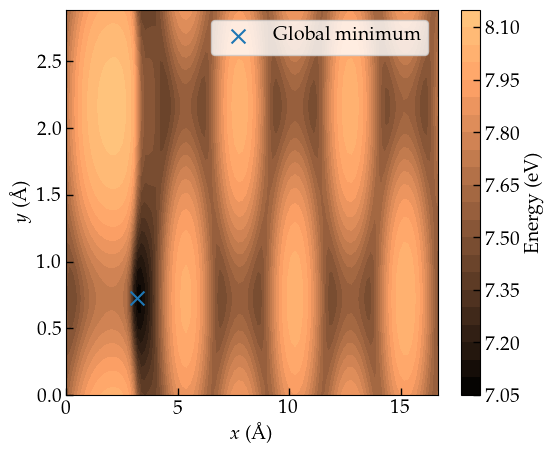

In [316]:

global_min = np.min(energy_grid)
global_min_pos = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
print(f'Global minimum position: x = {X[global_min_pos]:.2f} Å, y = {Y[global_min_pos]:.2f} Å')
print(f'Global minimum energy: {global_min} eV')

plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, energy_grid, levels=20, cmap='copper')
plt.colorbar(cp, label='Energy (eV)')
plt.xlabel('$x$ (Å)', fontsize=font_size)
plt.ylabel('$y$ (Å)', fontsize=font_size)
plt.scatter(X[global_min_pos], Y[global_min_pos], color='tab:blue', marker='x', s=100, label='Global minimum')
plt.legend()

plt.show()


## **Task 2: Local search**

In [278]:

n_searches = 10
rand = np.random.RandomState(19)
tol = 0.1

# Find minimum using scipy optimize with gradient descent
min_positions = []
min_energies = []
global_min_check = []
for n in tqdm(range(n_searches)):
    # random starting position
    x0 = rand.uniform(0, xmax)
    y0 = rand.uniform(0, ymax)
    z0 = z_adatom
    initial_position = [x0, y0, z0]

    # objective function
    def objective_function(pos):
        position = [pos[0], pos[1], z_adatom]
        energy = calculate_adatom_energy(surface, position)
        return energy

    result = scipy.optimize.minimize(objective_function, initial_position[:2], method='L-BFGS-B',
                                     bounds=[(0, xmax), (0, ymax)])
    min_x, min_y = result.x
    min_position = [min_x, min_y, z_adatom]
    min_energy = calculate_adatom_energy(surface, min_position)

    min_positions.append(min_position)
    min_energies.append(min_energy)
    global_min_check.append(abs(min_energy - global_min) < tol)
    

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [279]:

print(f'Number of times global minimum found: {sum(global_min_check)} out of {n_searches} searches')


Number of times global minimum found: 3 out of 10 searches


## **Task 3: Bayesian optimization**

In [ ]:

def A(x, y, model, beta):

    pos = np.vstack([x.ravel(), y.ravel()]).T
    mu, var = model.predict(pos)
    sigma = np.sqrt(var)

    return - mu + beta * sigma

def find_new_sample(A_values, x, y):
 
    index = np.argmax(A_values)
    x_new = x.ravel()[index]
    y_new = y.ravel()[index]

    return x_new, y_new

def bay_optimizer(kernel, x, y, beta, positions, Es, its, tol):
    
    model = GPy.models.GPRegression(np.array(positions), np.array(Es).reshape(-1, 1), kernel)
    model.optimize_restarts(verbose=False, num_restarts=10)

    history = {
        'positions': [], 
        'energies': [], 
        'A_values': []
        }
    for _ in tqdm(range(its)):

        A_values = A(x, y, model, beta)
        new_x, new_y = find_new_sample(A_values, x, y)
        new_position = [new_x, new_y, z_adatom]
        new_energy = calculate_adatom_energy(surface, new_position)

        positions.append([new_x, new_y])
        Es.append(new_energy)

        model.set_XY(np.array(positions), np.array(Es).reshape(-1, 1))
        # model.optimize()

        history['positions'].append([new_x, new_y])
        history['energies'].append(new_energy)
        history['A_values'].append(A(new_x, new_y, model, beta))

        last_5_diffs = np.array([abs(e - new_energy) for e in Es[-5:]])
        if np.all(last_5_diffs < tol):
            print('Convergence reached.')
            return history, model
        
    return history, model


In [341]:

x_dense, y_dense = np.linspace(0., xmax, 500), np.linspace(0., ymax, 500)
X_dense, Y_dense = np.meshgrid(x_dense, y_dense)

betas = [0.5, 1, 2, 3, 5, 10]
n_samples = 5
rand = np.random.RandomState(1337)
x_indices = rand.randint(0, len(X_dense.ravel()), n_samples)
y_indices = rand.randint(0, len(Y_dense.ravel()), n_samples)

delta_E = np.max(energy_grid) - np.min(energy_grid)
var0 = (delta_E / 2) ** 2
print(f'Initial variance prior set to: {var0} eV^2')

results = {
    'beta': [],
    'positions': [],
    'energies': [],
    'A_values': []
    }
for beta in betas:
    k1 = GPy.kern.RBF(input_dim=2)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(2.0, 1.0), warning=False)
    k1['variance'].set_prior(GPy.priors.Gamma(2.0, var0 / 2.0), warning=False)
    k2 = GPy.kern.Bias(input_dim=2)
    kernel = k1 + k2

    random_positions = []
    random_Es = []
    for i in range(n_samples):
        random_positions.append([X_dense.ravel()[x_indices[i]], Y_dense.ravel()[y_indices[i]]])
        position = [X_dense.ravel()[x_indices[i]], Y_dense.ravel()[y_indices[i]], z_adatom]
        energy = calculate_adatom_energy(surface, position)
        random_Es.append(energy)
 
    history, model = bay_optimizer(kernel, X_dense, Y_dense, beta=beta, positions=random_positions, Es=random_Es, its=60, tol=1e-6)
    results['beta'].append(beta)
    results['positions'].append(history['positions'])
    results['energies'].append(history['energies'])
    results['A_values'].append(history['A_values'])


Initial variance prior set to: 0.27173721411907964 eV^2


 47%|████▋     | 28/60 [00:10<00:12,  2.57it/s]

Convergence reached.



 75%|███████▌  | 45/60 [00:21<00:07,  2.08it/s]

Convergence reached.



 58%|█████▊    | 35/60 [00:14<00:10,  2.42it/s]

Convergence reached.



 48%|████▊     | 29/60 [00:11<00:12,  2.49it/s]

Convergence reached.



 60%|██████    | 36/60 [00:16<00:11,  2.14it/s]

Convergence reached.



 73%|███████▎  | 44/60 [00:23<00:08,  1.83it/s]

Convergence reached.


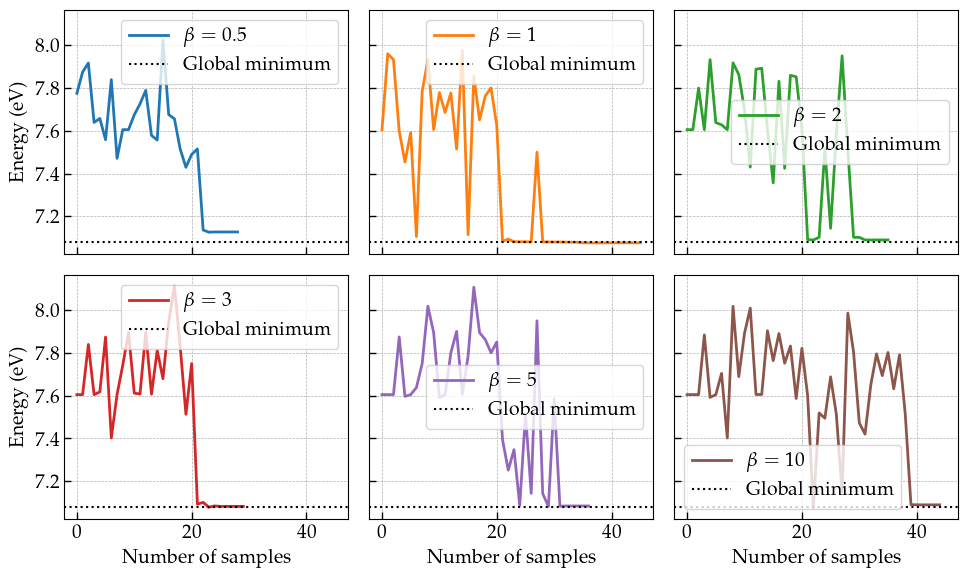

In [346]:

fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, beta in enumerate(betas):
    positions = results['positions'][i]
    energies = results['energies'][i]
    A_values = np.array(results['A_values'][i]).flatten()

    axs[i // 3, i % 3].plot(np.arange(len(energies)), energies, label=f'$\\beta = {beta}$', color=colors[i], linewidth=2)
    axs[i // 3, i % 3].axhline(global_min, color='k', linestyle=':', label='Global minimum')
    axs[i // 3, i % 3].legend()
    if i // 3 == 1:
        axs[i // 3, i % 3].set_xlabel('Number of samples', fontsize=font_size)
    if i % 3 == 0:
        axs[i // 3, i % 3].set_ylabel('Energy (eV)', fontsize=font_size)
    axs[i // 3, i % 3].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [354]:

beta = 3
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].set_prior(GPy.priors.Gamma(2.0, 1.0), warning=False)
k1['variance'].set_prior(GPy.priors.Gamma(2.0, var0 / 2.0), warning=False)
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2

n_initial_samples = 5
rng = np.random.RandomState(19)
x_indices = rand.randint(0, len(X.ravel()), n_initial_samples)
y_indices = rand.randint(0, len(Y.ravel()), n_initial_samples)

random_positions = []
random_Es = []
for i in range(n_initial_samples):
    random_positions.append([X.ravel()[x_indices[i]], Y.ravel()[y_indices[i]]])
    position = [X.ravel()[x_indices[i]], Y.ravel()[y_indices[i]], z_adatom]
    energy = calculate_adatom_energy(surface, position)
    random_Es.append(energy)

history, model = bay_optimizer(kernel, X, Y, beta=beta, positions=random_positions, Es=random_Es, its=50, tol=1e-6)


100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


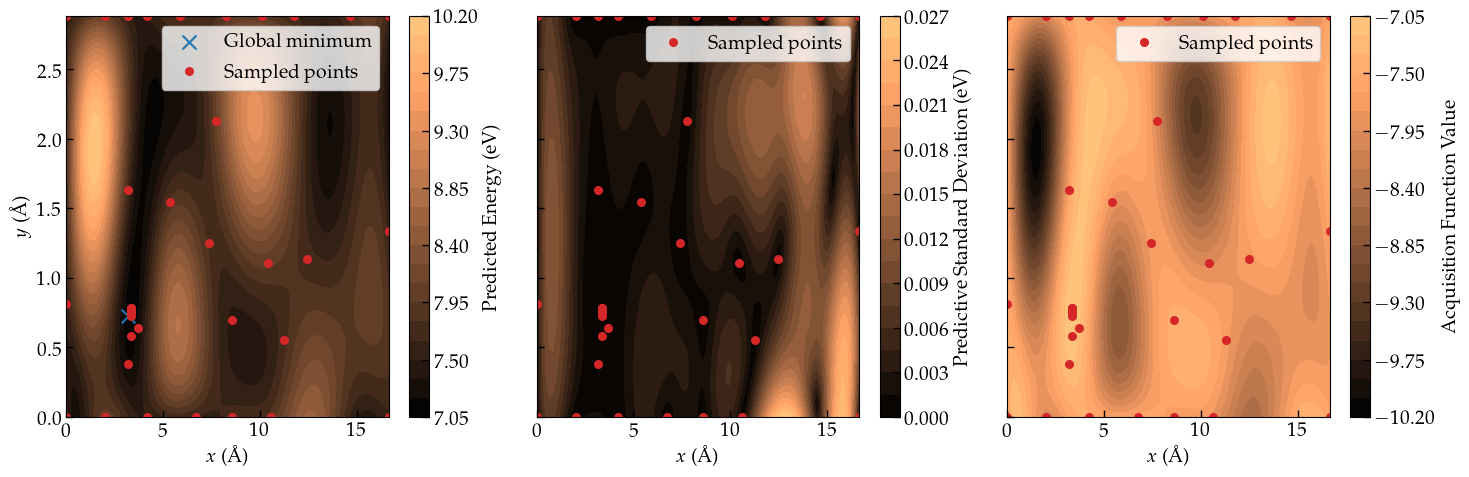

In [353]:

grid_positions = np.vstack([X.ravel(), Y.ravel()]).T
mean_pred_grid, var_pred_grid = model.predict(grid_positions)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
cp = axs[0].contourf(X, Y, mean_pred_grid.reshape(X.shape), levels=20, cmap='copper')
fig.colorbar(cp, ax=axs[0], label='Predicted Energy (eV)')
axs[0].set_xlabel('$x$ (Å)', fontsize=font_size)
axs[0].set_ylabel('$y$ (Å)', fontsize=font_size)
axs[0].scatter(X[global_min_pos], Y[global_min_pos], color='tab:blue', marker='x', s=100, label='Global minimum')
axs[0].scatter(np.array(history['positions'])[:, 0], np.array(history['positions'])[:, 1], color='tab:red', marker='o', s=30, label='Sampled points')
axs[0].legend()

cp = axs[1].contourf(X, Y, np.sqrt(var_pred_grid).reshape(X.shape), levels=20, cmap='copper')
fig.colorbar(cp, ax=axs[1], label='Predictive Standard Deviation (eV)')
axs[1].scatter(np.array(history['positions'])[:, 0], np.array(history['positions'])[:, 1], color='tab:red', marker='o', s=30, label='Sampled points')
axs[1].legend()
axs[1].set_xlabel('$x$ (Å)', fontsize=font_size)

A_values_grid = A(X, Y, model, beta).reshape(X.shape)
cp = axs[2].contourf(X, Y, A_values_grid, levels=20, cmap='copper')
axs[2].scatter(np.array(history['positions'])[:, 0], np.array(history['positions'])[:, 1], color='tab:red', marker='o', s=30, label='Sampled points')
fig.colorbar(cp, ax=axs[2], label='Acquisition Function Value')
axs[2].legend()
axs[2].set_xlabel('$x$ (Å)', fontsize=font_size)

plt.tight_layout()
plt.show()


## **Task 4: Transition paths barriers**

In [335]:

n_initial_samples = 5
rng = np.random.RandomState(1337)
Ngrid = X.size

init_idx = rng.choice(Ngrid, size=n_initial_samples, replace=False)
positions = [[X.ravel()[i], Y.ravel()[i]] for i in init_idx ]
Es = [calculate_adatom_energy(surface, [X.ravel()[i], Y.ravel()[i], z_adatom]) for i in init_idx ]

start = np.array([X[global_min_pos], Y[global_min_pos]])
end = np.array([11, 2.1])
positions.append([start[0], start[1]])
Es.append(calculate_adatom_energy(surface, [start[0], start[1], z_adatom]))
positions.append([end[0], end[1]])
Es.append(calculate_adatom_energy(surface, [end[0], end[1], z_adatom]))

X_train = np.array(positions)
Y_train = np.array(Es).reshape(-1, 1)

k1 = GPy.kern.RBF(input_dim=2, ARD=True) # ARD can help with anisotropy
k1.lengthscale.set_prior(GPy.priors.Gamma(2.0, 1.0), warning=False)
k1.variance.set_prior(GPy.priors.Gamma(2.0, var0 / 2.0), warning=False)
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2

general_model = GPy.models.GPRegression(X_train, Y_train, kernel)
general_model.optimize_restarts(num_restarts=10, verbose=False)
print(general_model)



Name : GP regression
Objective : 15.769254109130587
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors   
  sum.rbf.variance         |     0.5657671967876946  |      +ve      |  Ga(2, 0.14)
  sum.rbf.lengthscale      |                   (2,)  |      +ve      |   Ga(2, 1)  
  sum.bias.variance        |      57.81073185017305  |      +ve      |             
  Gaussian_noise.variance  |  6.045823069487393e-22  |      +ve      |             


In [336]:

grid_positions = np.vstack([X.ravel(), Y.ravel()]).T  # (Ngrid, 2)
beta = 1e6
max_new_samples = 200
results = {
    'n_samples': [], 
    'rmse_grid': [], 
    'train_sizes': []
    }

# Initial RMSE on full grid (with current model)
mu_grid, var_grid = general_model.predict(grid_positions)
rmse0 = np.sqrt(np.mean((mu_grid.ravel() - energy_grid.ravel())**2))
results['n_samples'].append(X_train.shape[0])
results['rmse_grid'].append(rmse0)

for i in tqdm(range(max_new_samples)):
    A_vals = A(X, Y, general_model, beta).ravel()  # flattened
    new_x, new_y = find_new_sample(A_vals, X, Y)
    new_E = calculate_adatom_energy(surface, [new_x, new_y, z_adatom])

    X_train = np.vstack([X_train, [new_x, new_y]])
    Y_train = np.vstack([Y_train, [[new_E]]])

    general_model.set_XY(X_train, Y_train)

    # optionally re-optimize hyperparameters every few steps
    if (i % 20) == 0:
        general_model.optimize_restarts(num_restarts=5, verbose=False)

    # compute RMSE on entire grid
    mu_grid, var_grid = general_model.predict(grid_positions)
    rmse = np.sqrt(np.mean((mu_grid.ravel() - energy_grid.ravel())**2))

    results['n_samples'].append(X_train.shape[0])
    results['rmse_grid'].append(rmse)


  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 19/200 [00:01<00:13, 13.29it/s] /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in scalar add
 20%|█▉        | 39/200 [00:04<00:16,  9.77it/s] /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/paramz/tr

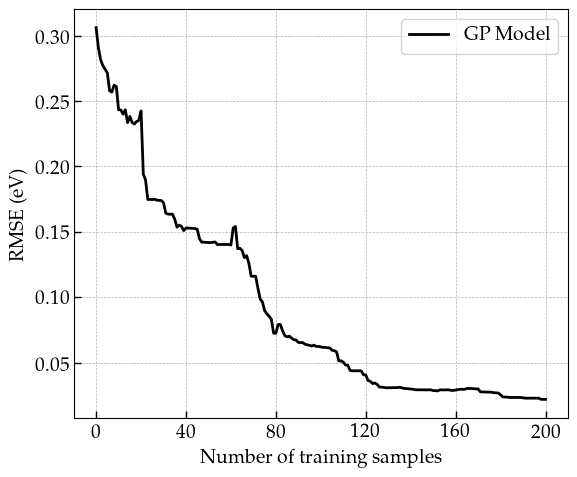

In [337]:

plt.figure(figsize=(6, 5))
plt.plot(np.arange(len(results['rmse_grid'])), results['rmse_grid'], label='GP Model', linewidth=2, color='k')
plt.xlabel('Number of training samples', fontsize=font_size)
plt.ylabel('RMSE (eV)', fontsize=font_size)
plt.legend()
plt.xticks([0, 40, 80, 120, 160, 200], fontsize=font_size)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [338]:

lam = np.linspace(0, 1, 100)
path = np.array([start + lam_i * (end - start) for lam_i in lam])
target_energies = np.array([calculate_adatom_energy(surface, [pos[0], pos[1], z_adatom]) for pos in path])

predicted_energies_bay, predicted_vars_bay = model.predict(path)
predicted_energies_gen, predicted_vars_gen = general_model.predict(path)
predicted_energies_gen = predicted_energies_gen.ravel()


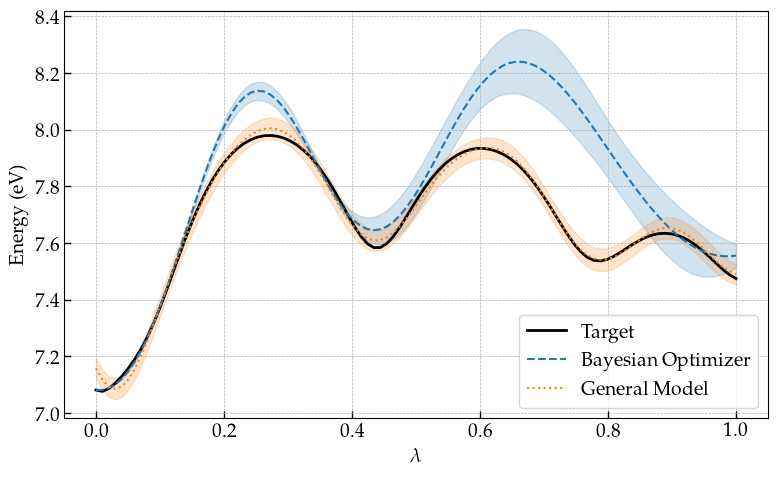

In [339]:

fig, axs = plt.subplots(1, 1, figsize=(8, 5))
axs.plot(lam, target_energies, label='Target', color='black', linewidth=2)
axs.plot(lam, predicted_energies_bay.ravel(), label='Bayesian Optimizer', linestyle='--')
axs.plot(lam, predicted_energies_gen, label='General Model', linestyle=':')
axs.fill_between(lam, 
                    predicted_energies_bay.ravel() - np.sqrt(predicted_vars_bay.ravel()),
                    predicted_energies_bay.ravel() + np.sqrt(predicted_vars_bay.ravel()),
                    color='tab:blue', alpha=0.2)
axs.fill_between(lam, 
                    predicted_energies_gen - np.sqrt(predicted_vars_gen.ravel()),
                    predicted_energies_gen + np.sqrt(predicted_vars_gen.ravel()),
                    color='tab:orange', alpha=0.2)
axs.set_xlabel('$\\lambda$', fontsize=font_size)
axs.set_ylabel('Energy (eV)', fontsize=font_size)
axs.legend()
axs.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


---